# DESeq2 tests of Timberlake OTUs via phyloseq, Dev vers.
- Includes DESeq2 Transforms, linear contrasts, plots of different, NMDS, and Heatmaps
- This preliminary code needs a bit of cleanup

In [1]:
library(phyloseq)
library(ggplot2)
library(RColorBrewer)
library(stringr)
library(reshape2)

suppressMessages(library(vegan))
suppressMessages(library(DESeq2))
suppressMessages(library(gplots))

## Import and pre-process files -- MODULE now exists in salinity OTU notebook

In [2]:
## IMPORT OTU TABLE 
# Raw (w. taxon)
TL_otu_raw <- read.table("Timberlake_iTags_OTU_noSoil.txt", sep='\t', header=TRUE, row.names=1)
#TL_otu_raw <- read.table("Timberlake_iTags_OTUraw.txt", sep='\t', header=TRUE, row.names=1)   # pre-drop source soil...
TL_otu_tax <-data.frame(OTU= row.names(TL_otu_raw), Taxonomy = TL_otu_raw$Consensus.lineage)   # get taxonomy        #head(TL_otu_raw)

In [3]:
# Filter OTU table to > 99 reads  -- Note if AGG or Grep, Agg, don't used filtered.
TL_otu_raw$OTU_tot = rowSums(TL_otu_raw[,1:(ncol(TL_otu_raw)-1)])  # Get OTU totals
TL_otu_F100 = TL_otu_raw[(TL_otu_raw$OTU_tot > 99), ]              # Filter by total
TL_otu_F100 = TL_otu_F100[,1:(ncol(TL_otu_F100)-1)]    

In [4]:
### IMPORT Sample mapping
map_both <-read.table("Timberlake_sample_map_both.txt", sep="\t", header=TRUE)                                    #head(map_both) # dim(map_both) # 50 x 11  - note iTag dropouts
map_iTag <-map_both[!(is.na(map_both$Itag_sample)),]                                          # drop NA in itag    # head(map_iTag) # dim(map_iTag) # now 43 x11, note OTU_ID is extra colname in OTU table
map_iTag <- map_iTag[order(map_iTag$itag_meta_order),]                                        # sort by index
map_iTag_only <- data.frame(Sample=map_iTag$Samp, Treat=map_iTag$Treat, Depth=map_iTag$Depth) # combine select cols. 
map_iTag_only<-map_iTag_only[1:33,]                                                           # drop source soil treats

In [5]:
### Reorder Samples in OTU table
TL_otu_F100t <- t(TL_otu_F100)                                               # transpose OTU table
TL_otu_F100T <- data.frame(Sample=row.names(TL_otu_F100t),TL_otu_F100t)      # add Sample col
map_iTag_only$index <-as.numeric(row.names(map_iTag_only))                   # Get ordering

TL_otu_F100_metaT <- merge(map_iTag_only, TL_otu_F100T, by="Sample", all.y=TRUE)  # Merge with metadata
TL_otu_F100_metaT <- TL_otu_F100_metaT[order(TL_otu_F100_metaT$index),]           # Sort samples by meta index 
row.names(TL_otu_F100_metaT)= TL_otu_F100_metaT$Sample                            # add back rownames
TL_otu_F100_reorder <- t(TL_otu_F100_metaT[,5:ncol(TL_otu_F100_metaT)])           # transpose while drop meta cols
row.names(TL_otu_F100_reorder) <- row.names(TL_otu_F100)                          # add back original OTU numbers (note as char)

# write table out
write.table(TL_otu_F100_reorder, "TL_OTU_F100_reorder.txt", sep='\t', row.names=TRUE, col.names=TRUE) 

In [6]:
### Finalize Sample MAP for Deseq
row.names(map_iTag_only) <- map_iTag_only$Sample  
map_iTag_PhyloDESeq <- map_iTag_only[,2:4]
map = map_iTag_PhyloDESeq

## Prepare data for Phyloseq

In [7]:
# Make OTU data matrix
OTUin <- data.frame(TL_otu_F100_reorder)
NoTaxa <- as.matrix(OTUin[,1:ncol(OTUin)-1])                   # Drop taxonomy

In [8]:
# Create OTU Table with Phyloseq
# OTU<-otu_table(NoTaxaT, taxa_are_rows=FALSE, errorIfNULL = TRUE)
# class(NoTaxa)<-"numeric"                                               # Needed for phyloseq
# OTU<-otu_table(NoTaxa, taxa_are_rows=TRUE, errorIfNULL = TRUE)         # Make OTU phyloseq
# head(OTU)

### Clean Taxonomy strings / cols, contaminants, unknowns

In [9]:
# Split Taxonomy strings
TaxSplit <- str_split_fixed(as.character(OTUin$Consensus.lineage),';', 6)
colnames(TaxSplit)<-c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus")      # previously made phyloseq b4 cleaning # TaxTable<-tax_table(NameNumber)   # Make Phyloseq table # head(TaxTable) # attributes(TaxSplit)

# Clean string delimiters
TaxSplit <- data.frame(TaxSplit)
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="k__",replace=""))
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="p__",replace=""))
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="c__",replace=""))
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="o__",replace=""))
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="f__",replace=""))
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="g__",replace=""))
#TaxSplit

# Joey-Phyloseq way below, didn't work for clade names that are numbers:
# TaxSplit<-gsub("g__([[:alpha:]])","\\1",TaxSplit) # for dropping tags
# TaxSplit<-gsub("g__(\\[)","\\1",TaxSplit)         # not sure, for empty?

# Clean misc: 
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="\\s\\(class\\)",replace=""))  # Drop " (class)", note double esc.
TaxSplit<-as.data.frame(sapply(TaxSplit, gsub,pattern="Candidatus",replace="Cand.")) # "Canditatus" genera -> "Cand."

row.names(TaxSplit) <-row.names(OTUin)  # Add back original OTU numbers              # head(TaxSplit) #TaxSplit

In [10]:
# Drop chloroplast & mitochondrial reads
TaxSplit2 <-data.frame(TaxSplit)                                        # not needed anymore, but leave for numbering # levels(TaxSplit2$Kingdom)  # TaxSplit2$Genus
TaxSplit3 <- TaxSplit2[!grepl("chloroplast", TaxSplit2$Kingdom),]       # drop chloropl.   
TaxSplit4 <- TaxSplit3[!grepl("mitochondria", TaxSplit3$Kingdom),]      # drop mitochon.             # dim(TaxSplit2) # dim(TaxSplit4)

# Drop reads with no phylum
TaxSplit5 <- TaxSplit4[!grepl("BacteriaKI", TaxSplit4$Phylum),]           # assigned KI only 
levels(TaxSplit5$Phylum)[levels(TaxSplit5$Phylum)==""] <- NA_character_   # assign NA to Empty Phyla # Magic, see is.na fxn doc
TaxClean0 <- TaxSplit5[!is.na(TaxSplit5$Phylum),]                          # drop NA rows            # dim(TaxClean) #levels(TaxClean$Phylum)  # TaxClean0

In [11]:
## Fill missing taxonomic levels, rebuild Tax Table ##
# Define Tax rank cols (needed below, avoiding attach method)
OTU <- row.names(TaxClean0)
Kingdom <- TaxClean0$Kingdom
Phylum <- TaxClean0$Phylum
class <- TaxClean0$Class
order <- TaxClean0$Order
family <- TaxClean0$Family
genus <- TaxClean0$Genus

# Fill missing, note capitalization for new vars, fill is sequential using new if missing
# Phylum<-ifelse(TaxClean0$phylum=="",paste(Kingdom,"KI",sep=""),paste(phylum))         # already deleted these
Class<-ifelse(TaxClean0$Class=="",paste(Phylum,"PH",sep=""),paste(class))
Order<-ifelse(TaxClean0$Order=="",paste(Class,"CL",sep=""),paste(order))
Family<-ifelse(TaxClean0$Family=="",paste(Order,"OR",sep=""),paste(family))
Genus<-ifelse(TaxClean0$Genus=="",paste(Family,"FA",sep=""),paste(genus))

# Rejoin Taxonomy DS elements
TaxRedo <-data.frame(OTU, Kingdom,Phylum,Class,Order,Family,Genus)                      # length(OTU);length(Kingdom);length(Phylum);length(Class);length(Order);length(Family);length(Genus)

# Cleanup multiple sequential tags
TaxRedo <-as.data.frame(sapply(TaxRedo, gsub,pattern="PHCLORFA",replace="PH"))
TaxRedo <-as.data.frame(sapply(TaxRedo, gsub,pattern="PHCLOR",replace="PH"))
TaxRedo <-as.data.frame(sapply(TaxRedo, gsub,pattern="PHCL",replace="PH"))
TaxRedo <-as.data.frame(sapply(TaxRedo, gsub,pattern="CLORFA",replace="CL"))
TaxRedo <-as.data.frame(sapply(TaxRedo, gsub,pattern="CLOR",replace="CL"))
TaxRedo <-as.data.frame(sapply(TaxRedo, gsub,pattern="ORFA",replace="OR"))


row.names(TaxRedo)<-TaxRedo$OTU  # add OTU # as row names                               # TaxRedo$Genus #dim(TaxRedo) #TaxRedo


In [12]:
# Prune OTU table by cleaned taxonomy
OTUin$OTU <-row.names(OTUin)                # Get filtered OTU table (OTUin), add OTU column       #head(OTUin)
KeepOTU <- data.frame(OTU=TaxRedo$OTU)      # Gather OTU numbers from cleaned taxonomy
row.names(KeepOTU)<-KeepOTU$OTU             # Add OTU row names for later.                # KeepOTU

cleanOTU <- merge(OTUin,TaxRedo, by="OTU")  # Merge with OTU table, keeping taxonomy for check...  # cleanOTU
row.names(cleanOTU) <- cleanOTU$OTU         # Make OTUs row.names after merge  
cleanOTU_tab <- cleanOTU[,1:ncol(OTUin)-1]  # OTU table, dropping New taxonomy                     # cleanOTU_tab
cleanOTU_table <-cleanOTU_tab[,-1]          # Drop OTU col for data matrix                         # cleanOTU_table  # dim(cleanOTU_table) # class(cleanOTU_tab)

# Write out table?

## Phyloseq I\O to DESeq2

In [13]:
# Make phyloseq OTU table object
cleanOTU_table2<-data.matrix(cleanOTU_table)                                    # df -> data matrix -> numeric 
class(cleanOTU_table2)<-"numeric"                                               # Needed for phyloseq
OTU<-otu_table(cleanOTU_table2, taxa_are_rows=TRUE, errorIfNULL = TRUE)         # phyloseq OTU table      # attributes(OTU[1:5,1:5])  #OTU# dim(OTU)

In [14]:
# Make Phyloseq Taxonomy table, while dropping OTU col
FullTax<-cleanOTU[,(ncol(cleanOTU_table)+2):ncol(cleanOTU)]         # Make new taxonomy table which includes full lineage
TaxTable<-tax_table(FullTax)                                        # make Phyloseq taxonomy object
colnames(TaxTable) <- colnames(FullTax)                             # Add back colnames
row.names(TaxTable) <- row.names(FullTax)                           # Add back rownames     # TaxTable # dim(TaxTable)

Warning message in .local(object):
“Coercing from data.frame class to character matrix 
prior to building taxonomyTable. 
This could introduce artifacts. 
Check your taxonomyTable, or coerce to matrix manually.”

In [15]:
# Get sample data
Map<-sample_data(map[,1:2])
dim(Map)# Map

[1] 33  2

In [16]:
### Make PHYLOSEQ object
physeq = phyloseq(OTU,Map,TaxTable)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2034 taxa and 33 samples ]
sample_data() Sample Data:       [ 33 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 2034 taxa by 7 taxonomic ranks ]

In [17]:
# Assign control treatment, phyloseq patch before DESeq
sample_data(physeq)$Treat <- relevel(as.factor(get_variable(physeq, "Treat")), ref="Control")

### Out to DESeq

In [18]:
### phyloseq out TO DESeq2
OTU_phy2des <- phyloseq_to_deseq2(physeq, ~ Treat)
OTU_phy2des 

converting counts to integer mode


class: DESeqDataSet 
dim: 2034 33 
metadata(1): version
assays(1): counts
rownames(2034): 0 1 ... 998 999
rowData names(0):
colnames(33): TL_inc_d1_DI_ctrl_2 TL_inc_d1_DI_ctrl_3 ...
  TL_inc_d2_SO4_5A TL_inc_d2_SO4_5B
colData names(2): Treat Depth

## DESeq2 for Diff abund

In [19]:
# Wald test
OTU_phy2des <- DESeq(OTU_phy2des, test="Wald", fitType="parametric") # Test

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 121 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [20]:
# Look at DESeq fmt data set, includes estimated dispersions
OTU_phy2des

class: DESeqDataSet 
dim: 2034 33 
metadata(1): version
assays(5): counts mu cooks replaceCounts replaceCooks
rownames(2034): 0 1 ... 998 999
rowData names(30): baseMean baseVar ... maxCooks replace
colnames(33): TL_inc_d1_DI_ctrl_2 TL_inc_d1_DI_ctrl_3 ...
  TL_inc_d2_SO4_5A TL_inc_d2_SO4_5B
colData names(4): Treat Depth sizeFactor replaceable

In [21]:
## Get results of tests off all vs. control
# res <- results(OTU_phy2des)
# resultsNames(OTU_phy2des)
# summary(res)

In [22]:
# Plot results
# options(repr.plot.width=4, repr.plot.height=4)
# plotMA(res) #, ylim=c(-2,2))  

In [23]:
# Likelihood ratio test, "ANOVA - like" for mulitple factors 
# -- note here some are sig again, unlike above Wald test
# lrt <- DESeq(OTU_phy2des, test="LRT", reduced=~1)
# res_LRT <- results(lrt)
# res_LRT

In [24]:
# Plot results of LRT
# options(repr.plot.width=4, repr.plot.height=4)
# plotMA(res_LRT) #, ylim=c(-2,2))

## DESeq2 Linear contrasts

### Function for linear contrasts with p > filter, FC cutoff

In [25]:
# Function for linear contrasts, results cutoff and merge with Ontology
DSq_cntrstF = function(Treat_col, Treat1, Treat2) {                               # Treat_col: column with treatment data
    alpha = 0.05                                                                  # Treat1: for increase compared with Ref
    FC = 1                                                                        # Treat2: Ref for comparison  

    T1_T2_De <- results(OTU_phy2des,contrast = c(Treat_col, Treat1, Treat2),independentFiltering = FALSE) # DESeq2 results
    T1_T2_DeS <- T1_T2_De[which(T1_T2_De$padj < alpha), ]                         # filter by alpha 
    
    
    T1_T2_DeSQ = cbind(as(T1_T2_DeS, "data.frame"), as(tax_table(physeq)[rownames(T1_T2_DeS), ], "matrix"))  #Bind taxanomic information to final results table.
    T1_T2_DeSQ <-data.frame(T1_T2_DeSQ)                                           # make df 
    T1_T2_DeSQ$OTU_ID <-row.names(T1_T2_DeSQ)                                     # add OTU_ID from rownames

     
    # Merge with CNP ontology, filter FC > 1 
    #T1_T2_DeSQ <- merge(T1_T2_DeSQ, BGC_ont_col, by ='KO')                       # merge w Ontology
    T1_T2_DeSQ_FC1 <- T1_T2_DeSQ[abs(T1_T2_DeSQ$log2FoldChange) > FC,]            # filter FC > 1 
    
    return(T1_T2_DeSQ_FC1)
}

In [26]:
# Test contrasts fxn: 
ASW_Ctrl_DeSQ_FC <- DSq_cntrstF("Treat", "ASW", "Control")                        # ASW_Ctrl_DeSQ_FC

In [27]:
# Create ALL Contrasts results sets
ASW_Ctrl_FC <- DSq_cntrstF("Treat", "ASW", "Control")
ASW0S_Ctrl_FC <- DSq_cntrstF("Treat", "ASW_noS", "Control")
SO4_Ctrl_FC <- DSq_cntrstF("Treat", "SO4", "Control")
ASW_SO4_FC <- DSq_cntrstF("Treat", "ASW", "SO4")
ASW_ASW0S_FC <- DSq_cntrstF("Treat","ASW", "ASW_noS")
ASW0S_SO4_FC <- DSq_cntrstF("Treat","ASW_noS","SO4")                              # ASW0S_SO4_FC

### Collect significnant OTUs, all treat contrasts

In [28]:
# gather KO lists
ASW_Ctrl_OTU <- data.frame(OTU=ASW_Ctrl_FC$OTU)
ASW0S_Ctrl_OTU <- data.frame(OTU=ASW0S_Ctrl_FC$OTU)
SO4_Ctrl_OTU <- data.frame(OTU=SO4_Ctrl_FC$OTU)
ASW_SO4_OTU <- data.frame(OTU=ASW_SO4_FC$OTU)
ASW_ASW0S_OTU <- data.frame(OTU=ASW_ASW0S_FC$OTU)
ASW0S_SO4_OTU <- data.frame(OTU=ASW0S_SO4_FC$OTU)

# Combine lists, make unique
Resp_OTU <- (rbind(ASW_Ctrl_OTU, ASW0S_Ctrl_OTU, SO4_Ctrl_OTU, ASW_SO4_OTU, ASW_ASW0S_OTU, ASW0S_SO4_OTU))
Resp_OTUu <- unique(Resp_OTU)                                                     # Resp_KO #length(Resp_KO)   # dim(Resp_KO) # dim(Resp_KOu)
row.names(Resp_OTUu) <-Resp_OTUu$OTU                                              # 
# Resp_OTUu

## Get DESeq2 variance stablized data set

In [29]:
OTU_phy2des_vs <- estimateSizeFactors(OTU_phy2des)
OTU_phy2des_vs <- estimateDispersions(OTU_phy2des)
OTU_phy2des_VST <- getVarianceStabilizedData(OTU_phy2des)                         # OTU_phy2des_VST

found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates


In [30]:
## REPLACE VST data with COUNTS
OTU_vs_counts <- counts(OTU_phy2des_vs, normalized=TRUE)                          # get counts                       #head(KO_vs_counts) 
OTU_table_VST <- data.frame(OTU_vs_counts)                                        # make df, shorten name

In [31]:
# Scale OTU VST table counts to CPM (Counts per million)
sampTots<-colSums(OTU_table_VST)                                                  # Get sample totals   #[,1:ncol(OTU_table_VST)-1]) 
OTU_VST_CPM<-sweep(OTU_table_VST*1000000,2,sampTots,'/')                          # Sweep matrix by:[div. by samp total * 1e+06]    # colSums(OTU_VST_CPM)#head(OTU_VST_CPM)  # OTU_VST_CPM
OTU_VST_CPM$OTU <- row.names(OTU_VST_CPM)                                         # Add OTU as column for later merges    # head(OTU_VST_CPM) # colSums(KO_VST_CPM) # KO_VST_CPM

In [32]:
### Add Taxonomy data                                                             # source: #head(tax_table(physeq))
Taxonomy <- data.frame(tax_table(physeq))                                         # make DF from phyloseq object 
Taxonomy$OTU <- row.names(Taxonomy)                                               # Add OTU number for merge 

OTU_VST_CPM_tax <- merge(OTU_VST_CPM, Taxonomy, by="OTU")                              # OTU_VST_CPM_tax

In [33]:
# get OTU Counts from DE OTUs by MERGE 
OTU_table_VST_resp <- merge(Resp_OTUu, OTU_VST_CPM, by="OTU")                               # merge                #dim(KO_table_VST_resp0)  # dim(Resp_KOu)

# Merge with Taxonomy
OTU_table_VST_resp_tax <- merge(OTU_table_VST_resp, Taxonomy, by="OTU")
OTU_table_VST_resp_tax <- OTU_table_VST_resp_tax[order(OTU_table_VST_resp_tax$Phylum),] 
#OTU_table_VST_resp_tax

## Make barplots  - Treatment responsive OTUs

In [34]:
# Prepare data matrix                       # IN: OTU_table_VST_resp_tax 
OTU_VST_resp_tax<-OTU_table_VST_resp_tax[order(OTU_table_VST_resp_tax$Consensus.lineage),] # sort by lineage  # OTU_VST_resp_tax
row.names(OTU_table_VST_resp_tax)<-OTU_table_VST_resp_tax$OTU                              # FIX OTU rownames # OTU_VST_resp_tax
OTU_VST_respM <- data.matrix(OTU_VST_resp_tax[,2:(ncol(OTU_VST_resp_tax)-7)])              # get ONLY count data, matrix

# Get plotting categories, phyla + protebacterial classes
Phlya_cat <- ifelse(OTU_VST_resp_tax$Phylum == "Proteobacteria", paste(OTU_VST_resp_tax$Class), paste(OTU_VST_resp_tax$Phylum)) # Phlya_cats
Phlya_cats <- as.factor(Phlya_cat)                                                         # Set as factor      # Phlya_cats

# Aggregate by Phyla_cats 
OTU_VST_respM_agg <- aggregate(OTU_VST_respM, by=list(Phlya_cats), FUN=sum)
colnames(OTU_VST_respM_agg)[1]<-"Tax"                                                      # rename groups Tax  #OTU_VST_respM_agg

# Clean up Taxa -- here by % comp, not yet by factor reorder                                           # OTU_VST_respM_agg 
OTU_VST_respM_agg$TaxTot <- rowSums(OTU_VST_respM_agg[,-1])                                # Get Tax total counts across samples 
OTU_VST_respM_agg$TotFrac<- (OTU_VST_respM_agg$TaxTot/sum(OTU_VST_respM_agg$TaxTot))                         # Get % Tax totals OTU_VST_respM_agg

# New Taxa names, only > 0.5%
OTU_VST_respM_agg$NewTax <- ifelse(OTU_VST_respM_agg$TotFrac > 0.005, paste(OTU_VST_respM_agg$Tax), paste("Other"))   #OTU_VST_respM_agg
newTax <- OTU_VST_respM_agg$NewTax                                                         # get only new taxa    # newTax
OTU_VST_respM_aggD <- OTU_VST_respM_agg[,2:(ncol(OTU_VST_respM_agg)-3)]                    # Get only data        # OTU_VST_respM_aggD
OTU_VST_respM_agg2 <- aggregate(OTU_VST_respM_aggD, by=list(newTax), FUN=sum)              # Aggregate by NEW Phyla_cats 
colnames(OTU_VST_respM_agg2)[1]<-"Tax2"                                                    # rename groups        # OTU_VST_respM_agg2  # dim(OTU_VST_respM_agg2)

# MELT using only % 2 data
OTU_VST_respM_agg2_melt <-melt(OTU_VST_respM_agg2)   # Reshape2 grabs correct defaults       #OTU_VST_respM_agg2_melt  # OTU_VST_respM[OTU_VST_respM==0] <-0.5     

Using Tax2 as id variables


In [35]:
# Make automated, semi-custom color pallete
ncolor<-nrow(OTU_VST_respM_agg2)                        # Get number of colors from Tax2 cats       # ncolor
cols<-colorRampPalette(brewer.pal(9, "Set1"))(ncolor)   # Make custom pallete with n colors         # cols

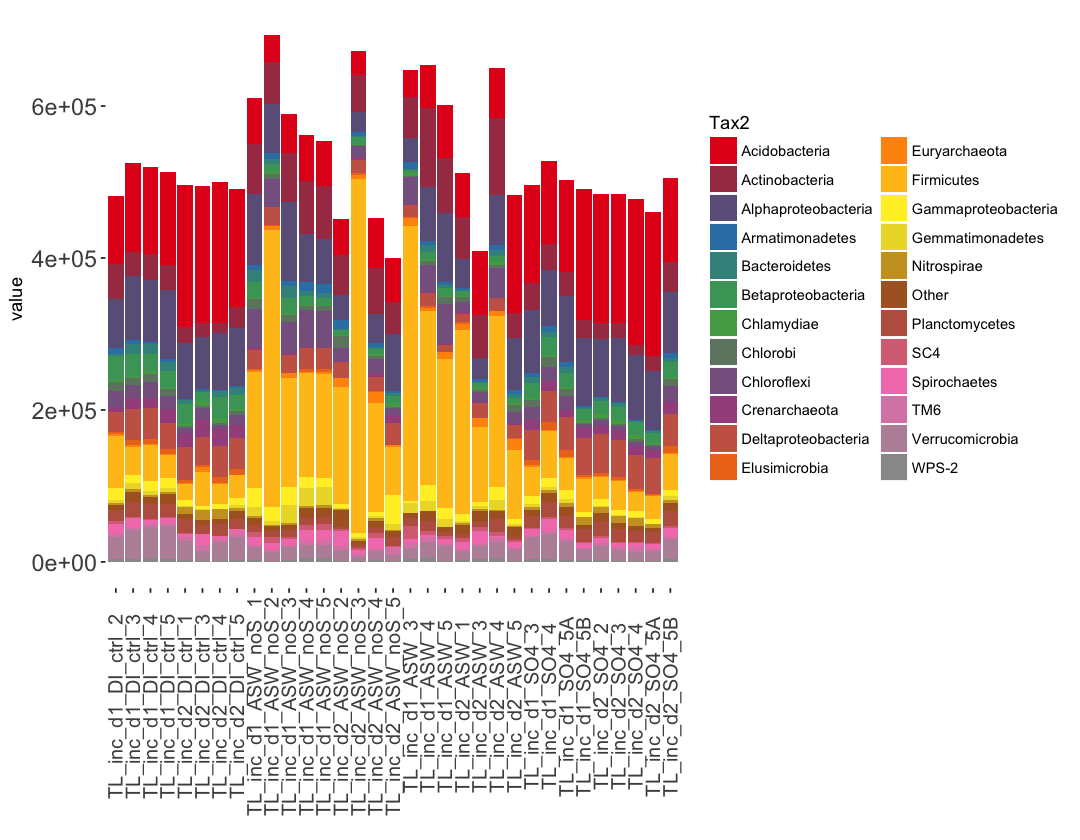

In [36]:
# Make Barplot, no custom colors yet
options(repr.plot.width=9, repr.plot.height=7)
pp<-ggplot(data=OTU_VST_respM_agg2_melt, aes(x=variable, y=value, fill=Tax2))
#pp<-ggplot(data=OTU_VST_respM_agg_melt, aes(x=variable, y=value, fill=Tax))
ppp<-pp+geom_bar(stat="identity")+scale_fill_manual(values=cols)

pppp<-ppp+ theme(axis.title.x = element_text(face="bold", colour="#FFFFFF", size=5),
                 axis.text.x  = element_text(angle=90, vjust=0.5, size=12),
                 axis.text.y=element_text(angle=0,vjust=0.5,size=14))

# Remove panel borders and grid lines  #
#ppppp<-
pppp + theme(panel.background = element_blank(),
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank())
#ppppp+scale_fill_brewer(palette="Set1")
#ppppp+scale_fill_manual(values=cols)
# increase legend size   #ppppp + theme(legend.text=element_text(size=14))


## Draw Heatmap with taxa colors

In [37]:
# Improved heatmap data with COLORS for Taxa, from barplot
# Data preparation

# Get Taxonomy colors from above, note rename for merge  
agg2taxCols<-data.frame(Phlya_cat = OTU_VST_respM_agg2$Tax2, cols) 

# Remake Phyla_cat # Copied from above, now column, FIX above?
OTU_VST_resp_tax$Phlya_cat <- ifelse(OTU_VST_resp_tax$Phylum == "Proteobacteria", paste(OTU_VST_resp_tax$Class), paste(OTU_VST_resp_tax$Phylum)) # Phlya_cats #OTU_VST_resp_tax

# Merge Responsive OTUs and colors by Phyla_cat
OTU_VST_resp_tax_cols <- merge(OTU_VST_resp_tax, agg2taxCols, by="Phlya_cat", all.x=TRUE)  #OTU_VST_resp_tax_cols

# Fix Tax2 names, replacing NAs 
OTU_VST_resp_tax_cols$Tax2 <- ifelse(is.na(OTU_VST_resp_tax_cols$cols), paste("Other"), paste(OTU_VST_resp_tax_cols$Phlya_cat)) # Phlya_cats # OTU_VST_resp_tax_cols

# Fix colors for "Other, replacing NAs
OtherCol=agg2taxCols$cols[agg2taxCols$Phlya_cat=="Other"] # Get color for "Other" # OtherCol
OTU_VST_resp_tax_cols$col2 <- ifelse(is.na(OTU_VST_resp_tax_cols$cols), paste(OtherCol), paste(OTU_VST_resp_tax_cols$cols)) # Phlya_cats # OTU_VST_resp_tax_cols # OTU_VST_resp_tax_cols

# Get color vector
TaxCol2<-OTU_VST_resp_tax_cols$col2     

# Get data matrix (no row labels)
RespTaxM <-data.matrix(OTU_VST_resp_tax_cols[3:(ncol(OTU_VST_resp_tax_cols)-10)])  # RespTaxM   
                                 
# Get Z-scores, log2
RespTaxMZ <- data.matrix(t(scale(t(log2(RespTaxM)), center=TRUE, scale=TRUE)))     # z-scores, log10, by row 

In [38]:
# Get treatment colors
trt_colors <- c('#cccccc','#cccccc','#cccccc','#cccccc','#cccccc', '#cccccc','#cccccc','#cccccc',
                '#fabe58', '#fabe58','#fabe58','#fabe58','#fabe58', '#fabe58','#fabe58','#fabe58','#fabe58',
                '#6bb96d','#6bb96d','#6bb96d','#6bb96d','#6bb96d', '#6bb96d','#6bb96d', 
                '#9ac5e0','#9ac5e0','#9ac5e0','#9ac5e0','#9ac5e0','#9ac5e0','#9ac5e0','#9ac5e0','#9ac5e0')

Warning message in heatmap.2(t(RespTaxMZ), Rowv = F, Colv = F, key = TRUE, trace = "none", :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(t(RespTaxMZ), Rowv = F, Colv = F, key = TRUE, trace = "none", :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”

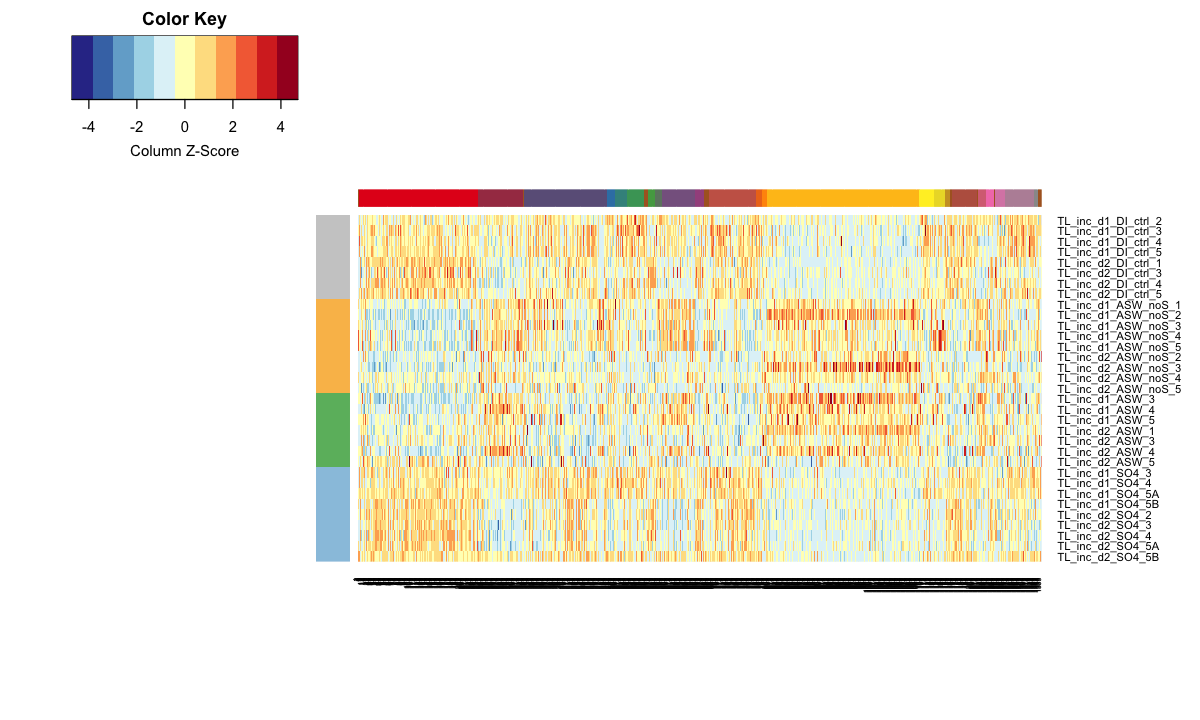

In [39]:
# Plot heatmap
options(repr.plot.width=10, repr.plot.height=6)
heatmap.2(t(RespTaxMZ), Rowv=F, Colv=F, key=TRUE, trace="none", density.info="none",scale="column",
          RowSideColors=trt_colors, ColSideColors = TaxCol2, margins = c(10, 10), col = rev(brewer.pal(11,"RdYlBu")))
# RowSideColors=trt_colors, ColSideColors = L2_colors,trace="none",


Warning message in heatmap.2(t(RespArchMZ), Rowv = T, Colv = F, key = TRUE, trace = "none", :
“Discrepancy: Colv is FALSE, while dendrogram is `both'. Omitting column dendogram.”

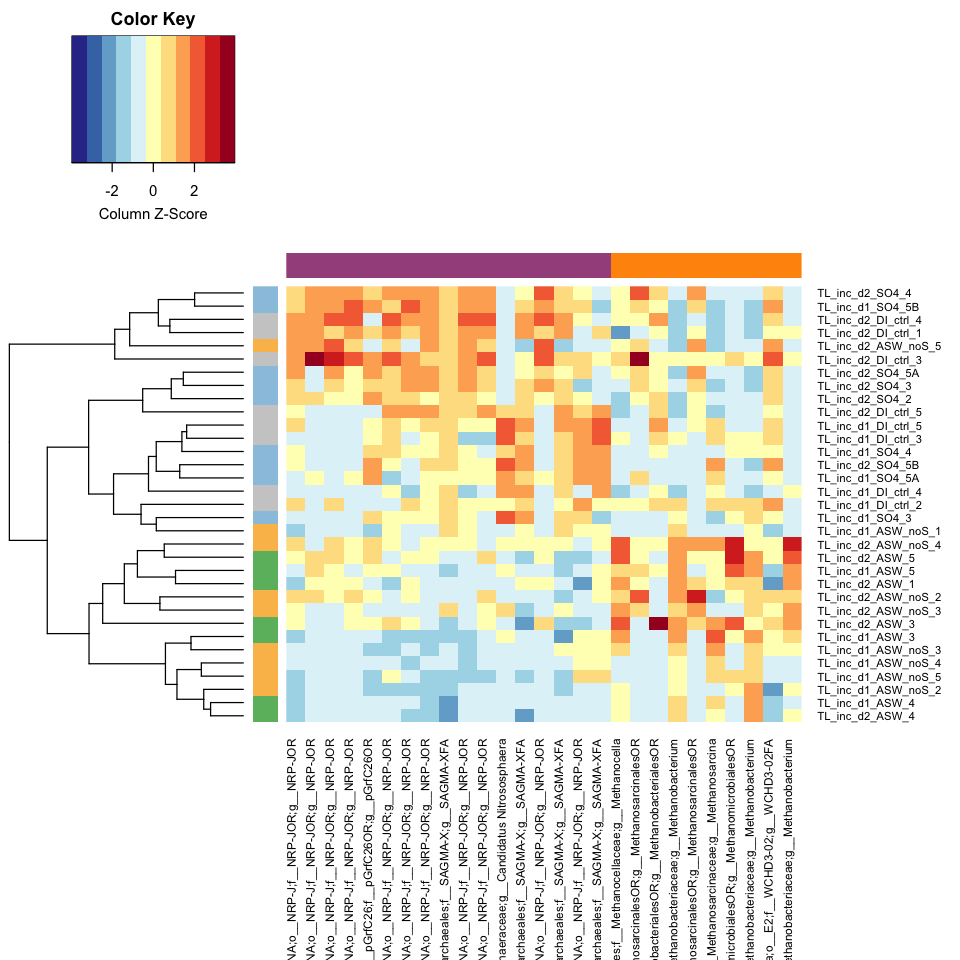

In [40]:
### ONLY ARCHAEA heatmap,                                                  
Arch_resp<-OTU_VST_resp_tax_cols[which(OTU_VST_resp_tax_cols$Kingdom=="Archaea"),]  # Subset from OTU_VST_resp_tax_cols  #Arch_resp
ArchCol2<-Arch_resp$col2                                                             # Get color vector  #TaxCol2
RespArchM <-data.matrix(Arch_resp[3:(ncol(Arch_resp)-10)])                          # Get data matrix (no row labels)     # RespTaxM   
RespArchMZ <- data.matrix(t(scale(t(log2(RespArchM)), center=TRUE, scale=TRUE)))    # Get Z-scores, log2 # z-scores, log10, by row 
row.names(RespArchMZ) <- Arch_resp$Consensus.lineage                                # rownames as full taxonomy
# RespArchMZ

# Plot basic heatmap
options(repr.plot.width=8, repr.plot.height=8)
heatmap.2(t(RespArchMZ), Rowv=T, Colv=F, key=TRUE, trace="none", density.info="none",scale="column", 
          RowSideColors=trt_colors, ColSideColors = ArchCol2, margins = c(15, 10), col = rev(brewer.pal(11,"RdYlBu")))


## NMDS PLOTS

### Define Plotting Function

In [41]:
biom_plot_cats_nmds <- function(biom, group, env){
  biomT<-t(biom)    # Transpose so cols are vars
  
  # Test ADONIS models, extract params
  bT_adonis <- adonis(biomT  ~ group, permutations=99, method="bray");
  R2 <- round(bT_adonis$aov.tab$R2[1], digits=3)
  P <- bT_adonis$aov.tab$"Pr(>F)"[1]
  
  # NMDS
  bT_mds<-suppressMessages(metaMDS(biomT[,-1], distance="bray",k=3, trymax=10));                  # run NMDS
  bT_mds_DF = data.frame(MDS1=bT_mds$points[,1], MDS2=bT_mds$points[,2], group)  # Make data frame
  stress=round(bT_mds$stress, digits = 3)                                      # get NMDS stress
  
  # Plot NMDS by assembly group
  pA <- ggplot(bT_mds_DF,aes(x=MDS1, y=MDS2, color=group))+geom_point()+stat_ellipse(level=0.95);
  pB <-pA + annotate("text", x = (0.9*(max(bT_mds_DF$MDS1))), y = max(bT_mds_DF$MDS2), label = paste("italic(R) ^ 2 ==", R2),
                     parse = TRUE);
  pC <-pB + annotate("text", x = (0.6*(min(bT_mds_DF$MDS1))), y = min(bT_mds_DF$MDS2), label = paste("italic(Stress):", stress),
                     parse = TRUE);
  pD <- pC + theme(legend.title=element_blank())
  
  return(pD)
}

Square root transformation
Wisconsin double standardization
Run 0 stress 0.04847573 
Run 1 stress 0.05032024 
Run 2 stress 0.04598177 
... New best solution
... Procrustes: rmse 0.05656211  max resid 0.2236497 
Run 3 stress 0.0490091 
Run 4 stress 0.04628101 
... Procrustes: rmse 0.01285791  max resid 0.05545583 
Run 5 stress 0.04847438 
Run 6 stress 0.05063208 
Run 7 stress 0.04625996 
... Procrustes: rmse 0.03424662  max resid 0.1606895 
Run 8 stress 0.04869061 
Run 9 stress 0.04625928 
... Procrustes: rmse 0.03429506  max resid 0.1608692 
Run 10 stress 0.04626081 
... Procrustes: rmse 0.03415762  max resid 0.1612699 
Run 11 stress 0.04628112 
... Procrustes: rmse 0.01285334  max resid 0.05534039 
Run 12 stress 0.04592423 
... New best solution
... Procrustes: rmse 0.005395663  max resid 0.01897308 
Run 13 stress 0.04918408 
Run 14 stress 0.04553325 
... New best solution
... Procrustes: rmse 0.0328612  max resid 0.1603136 
Run 15 stress 0.04852465 
Run 16 stress 0.05128316 
Run 17 s

Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”

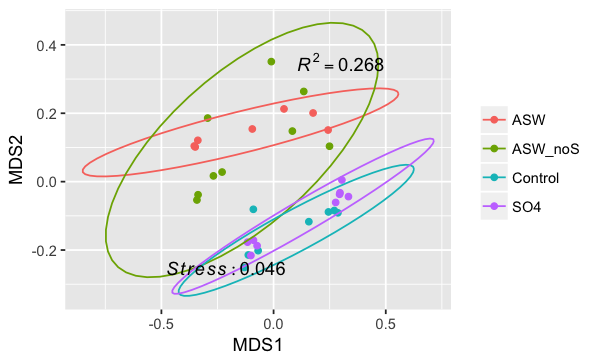

In [42]:
## ALL OTUs

# Get counts per sample,  from # KO_VST_CPM  not  KO_table_VST
OTU_table_VST_nk <- OTU_VST_CPM[, 1:(ncol(OTU_VST_CPM)-1)]  # Drop KO column, previously needed for merge  # KO_table_VST_nk
#KO_table_VST_nk <- KO_table_VST[, 1:(ncol(KO_table_VST)-1)]  # Drop KO column, previously needed for merge  # KO_table_VST_nk

# Get treatment vector
Treat <-map_iTag_only$Treat[1:ncol(OTU_table_VST_nk)]      # Treat

## PLOT
options(repr.plot.width=5, repr.plot.height=3)
#suppressWarnings(biom_plot_cats_nmds(KO_table_VST_nk, Treat))
suppressMessages(biom_plot_cats_nmds(OTU_table_VST_nk, Treat)) 

## Plotting functions for DESeq2

In [43]:
# Fold plot function, adapated from joey711.github.io/phyloseq-extensions/DESeq2.html
fold_plot = function(sigtab){
    
    # Phylum order - for colors
    x = tapply(sigtab$log2FoldChange, sigtab$Phylum, function(x) max(x))
    x = sort(x, TRUE)
    sigtab$Phylum <- factor(as.character(sigtab$Phylum), levels = names(x))
    
    # Genus order - for xlabels
    x = tapply(sigtab$log2FoldChange, sigtab$Genus, function(x) max(x))
    x = sort(x, TRUE)
    sigtab$Genus <- factor(as.character(sigtab$Genus), levels = names(x))
        
        
    #pt_size = (sigtab$baseMean/100)

    p <- ggplot(sigtab, aes(x=Genus, y=log2FoldChange, color=Phylum)) + geom_point(size=2) + 
        theme(axis.text.x = element_text(angle = 90))
    p + geom_point(aes(size = baseMean))
    }

In [44]:
# Volcano plot function
volc_plot = function(sigtab){
    # Phylum order
    x = tapply(sigtab$log2FoldChange, sigtab$Phylum, function(x) max(x))
    x = sort(x, TRUE)
    sigtab$Phylum <- factor(as.character(sigtab$Phylum), levels = names(x))
    # Genus order
    x = tapply(sigtab$log2FoldChange, sigtab$Genus, function(x) max(x))
    x = sort(x, TRUE)
    sigtab$Genus <- factor(as.character(sigtab$Genus), levels = names(x))
        
    pt_size = (sigtab$baseMean/100)

    ggplot(sigtab, aes(x=log2FoldChange, y=baseMean, color=Phylum)) + geom_point(size=2) + 
        theme(axis.text.x = element_text(angle = 90))
    }

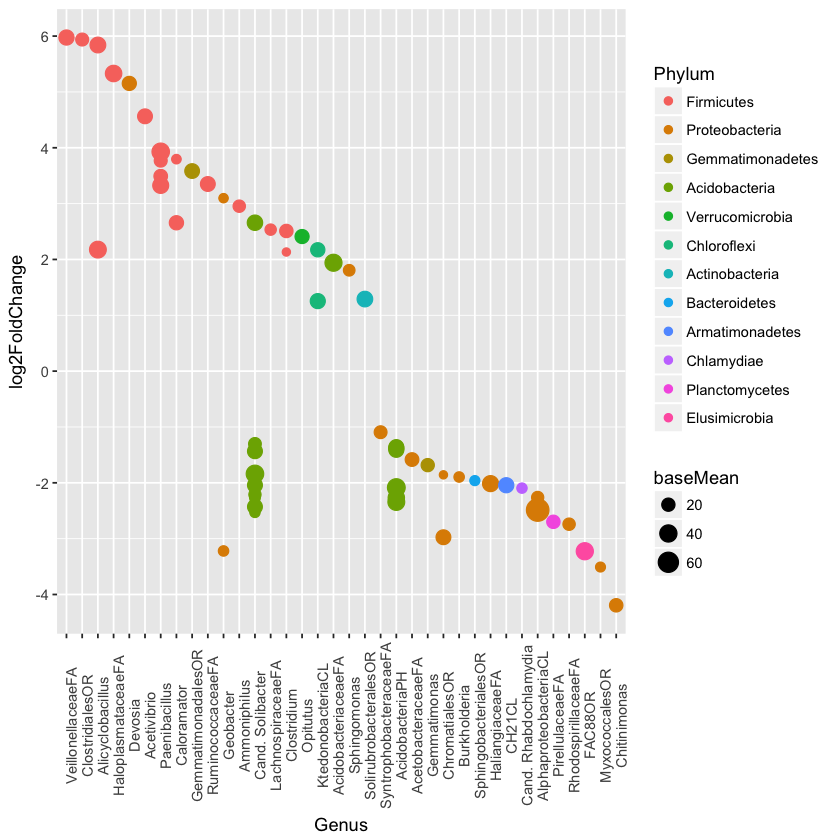

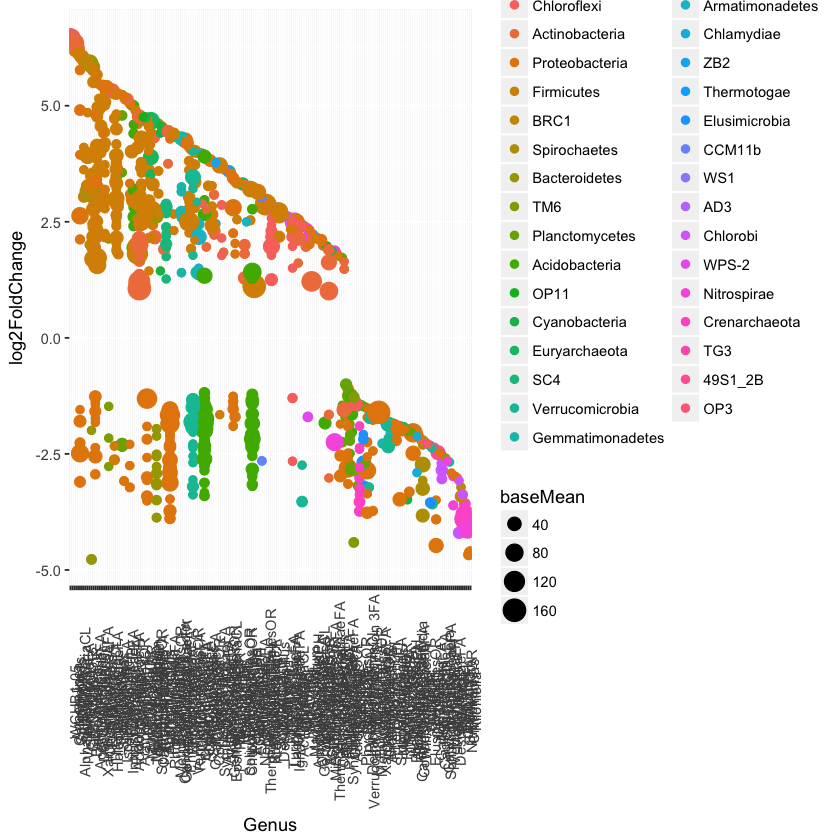

In [45]:
# Test
options(repr.plot.width=7, repr.plot.height=7)
fold_plot(ASW_Ctrl_FC[1:60,])
fold_plot(ASW_Ctrl_FC)

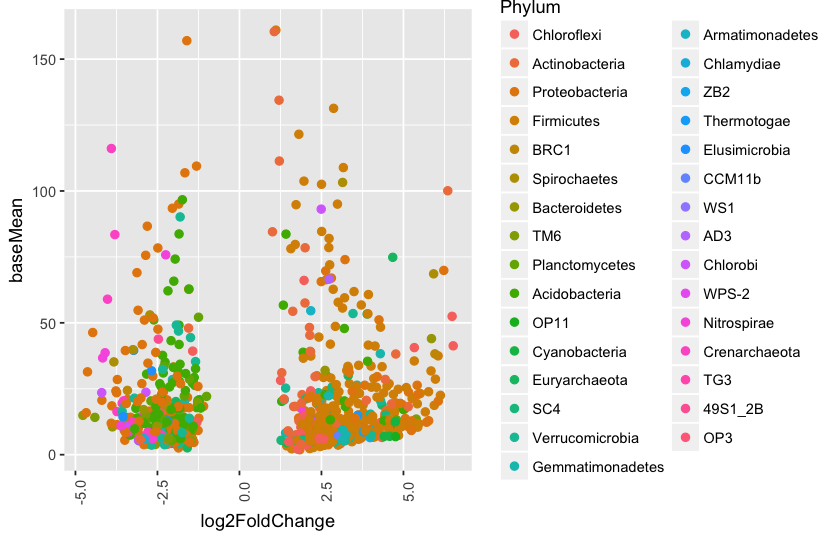

In [46]:
options(repr.plot.width=7, repr.plot.height=4.5)
volc_plot(ASW_Ctrl_FC)

## Archaea only

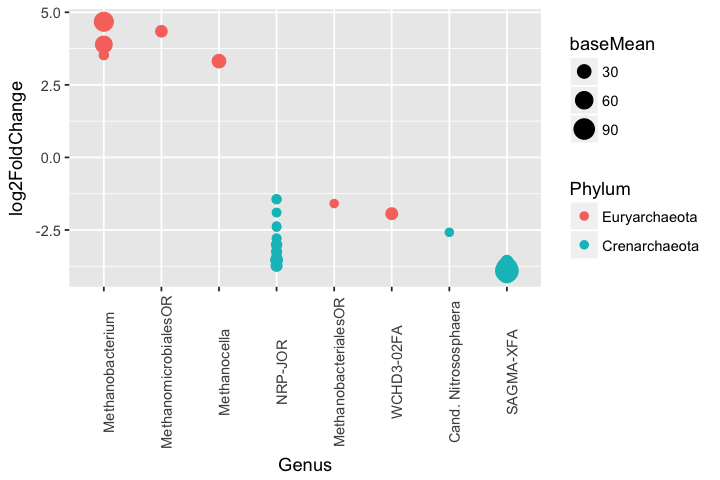

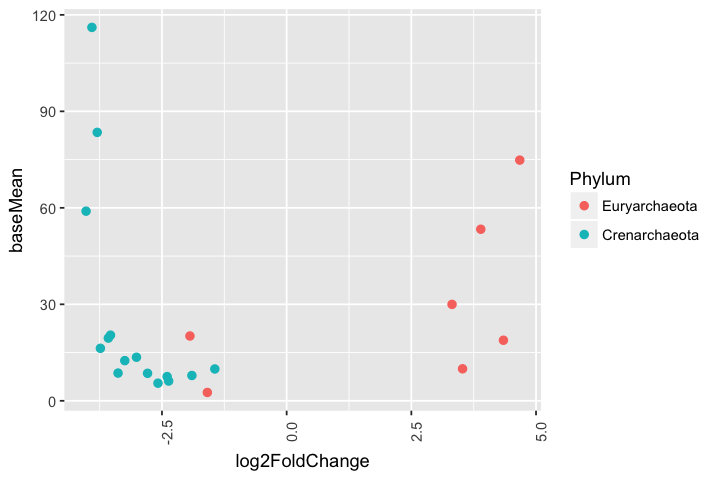

In [47]:
### ONLY ARCHAEA
ASW_Ctrl_FC_Arch<-ASW_Ctrl_FC[which(ASW_Ctrl_FC$Kingdom=="Archaea"),]
# ASW_Ctrl_FC_Arch

# Plot
options(repr.plot.width=6, repr.plot.height=4)
fold_plot(ASW_Ctrl_FC_Arch)
volc_plot(ASW_Ctrl_FC_Arch)

## Make exploratory plots

In [48]:
# Test plot with responsive archaea only (ASW vs. Control)
options(repr.plot.width=6, repr.plot.height=4)
#fold_plot(ASW_Ctrl_DeSQ_arch)

In [49]:
### Plot other combinations

In [50]:
## ASW no S
#fold_plot(ASW0S_Ctrl_DeSQ[1:50,])

In [51]:
#volc_plot(ASW0S_Ctrl_DeSQ[1:50,])

In [52]:
# SO4 only
#fold_plot(SO4_ASW_DeSQ[1:50,])
#fold_plot(SO4_ASW_DeSQ)

In [53]:
# volc_plot(SO4_ASW_DeSQ[1:50,])
# volc_plot(SO4_ASW_DeSQ)